## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

In [2]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from analyzer import Analyzer
from constants import *

## Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

In [5]:
samples = create_sine_dataset(100,50)
samples.size()

torch.Size([100, 50, 1])

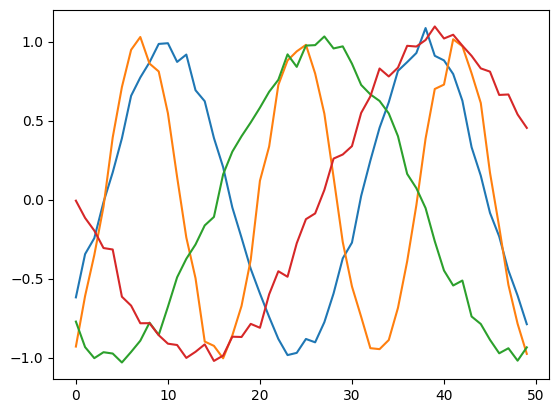

In [6]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

## LSTM Training

In [5]:
n_samples = 100
seq_len = 50
n_epochs = 200

In [6]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.70213
Epoch 10: Loss 0.27673
Epoch 20: Loss 0.09566
Epoch 30: Loss 0.04599
Epoch 40: Loss 0.03340
Epoch 50: Loss 0.02234
Epoch 60: Loss 0.01777
Epoch 70: Loss 0.01558
Epoch 80: Loss 0.01404
Epoch 90: Loss 0.01298
Epoch 100: Loss 0.01219
Epoch 110: Loss 0.01157
Epoch 120: Loss 0.01106
Epoch 130: Loss 0.01063
Epoch 140: Loss 0.01027
Epoch 150: Loss 0.00995
Epoch 160: Loss 0.00968
Epoch 170: Loss 0.00943
Epoch 180: Loss 0.00922
Epoch 190: Loss 0.00903


Text(0.5, 0, 'epoch')

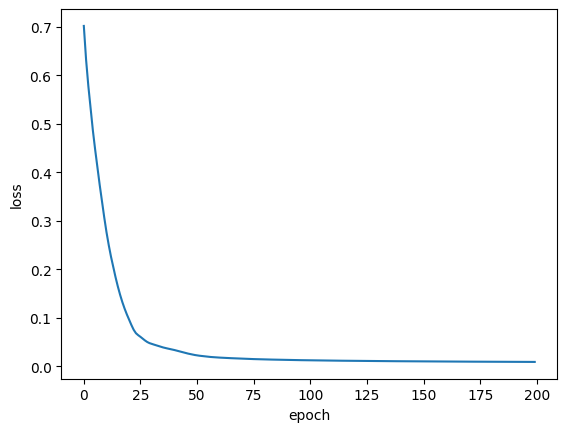

In [7]:
loss_lstm = train_lstm(lstm_model, lstm_data, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[0.4084],
        [0.3408],
        [0.5157],
        [0.6496],
        [0.7246]])
Generated shape: torch.Size([100, 1])
Generated values: tensor([[0.3694],
        [0.4623],
        [0.4322],
        [0.3051],
        [0.1289]])


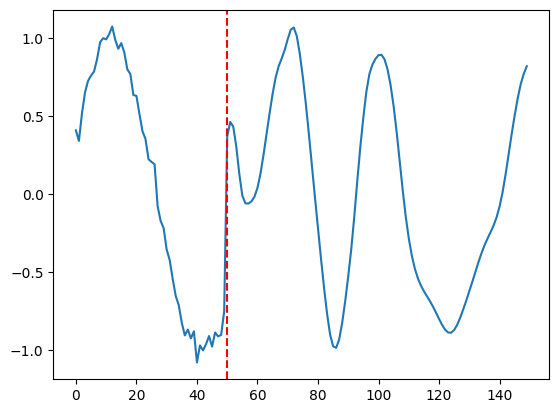

In [11]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 2*seq_len
generated, history_generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

## LSTM Visualization

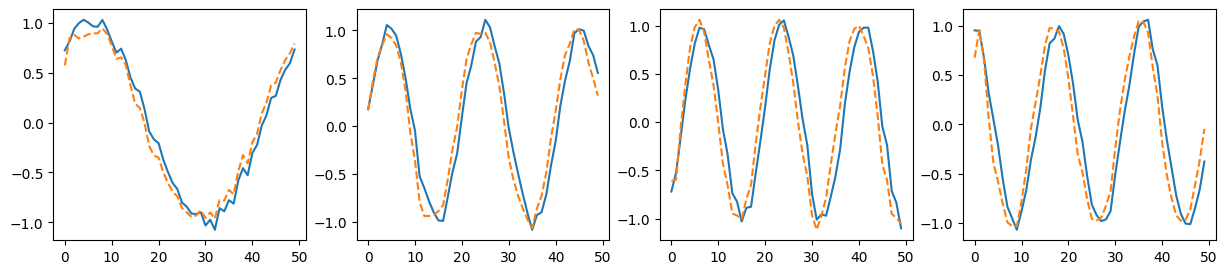

In [12]:
lstm_out, history_lstm = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

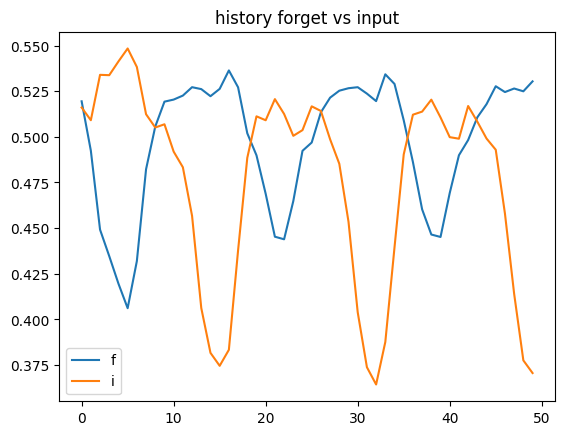

In [13]:
rand_index = random.randint(0,n_samples)
forget = [[t[rand_index, d].item() for t in history_lstm["forget"]] for d in range(16)]
input = [[t[rand_index, d].item() for t in history_lstm["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history forget vs input")
plt.legend()
plt.show()

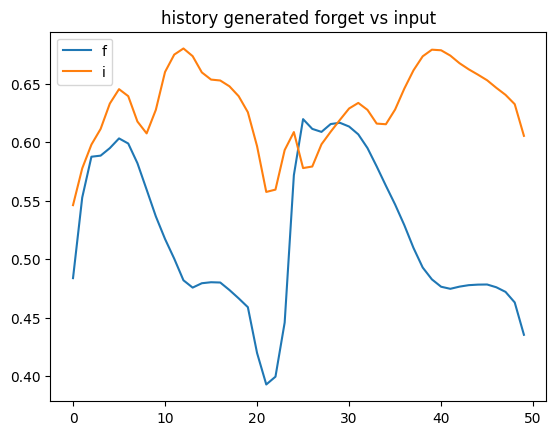

In [13]:
forget = [[t[0, d].item() for t in history_generated["forget"]] for d in range(16)]
input = [[t[0, d].item() for t in history_generated["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history generated forget vs input")
plt.legend()
plt.show()

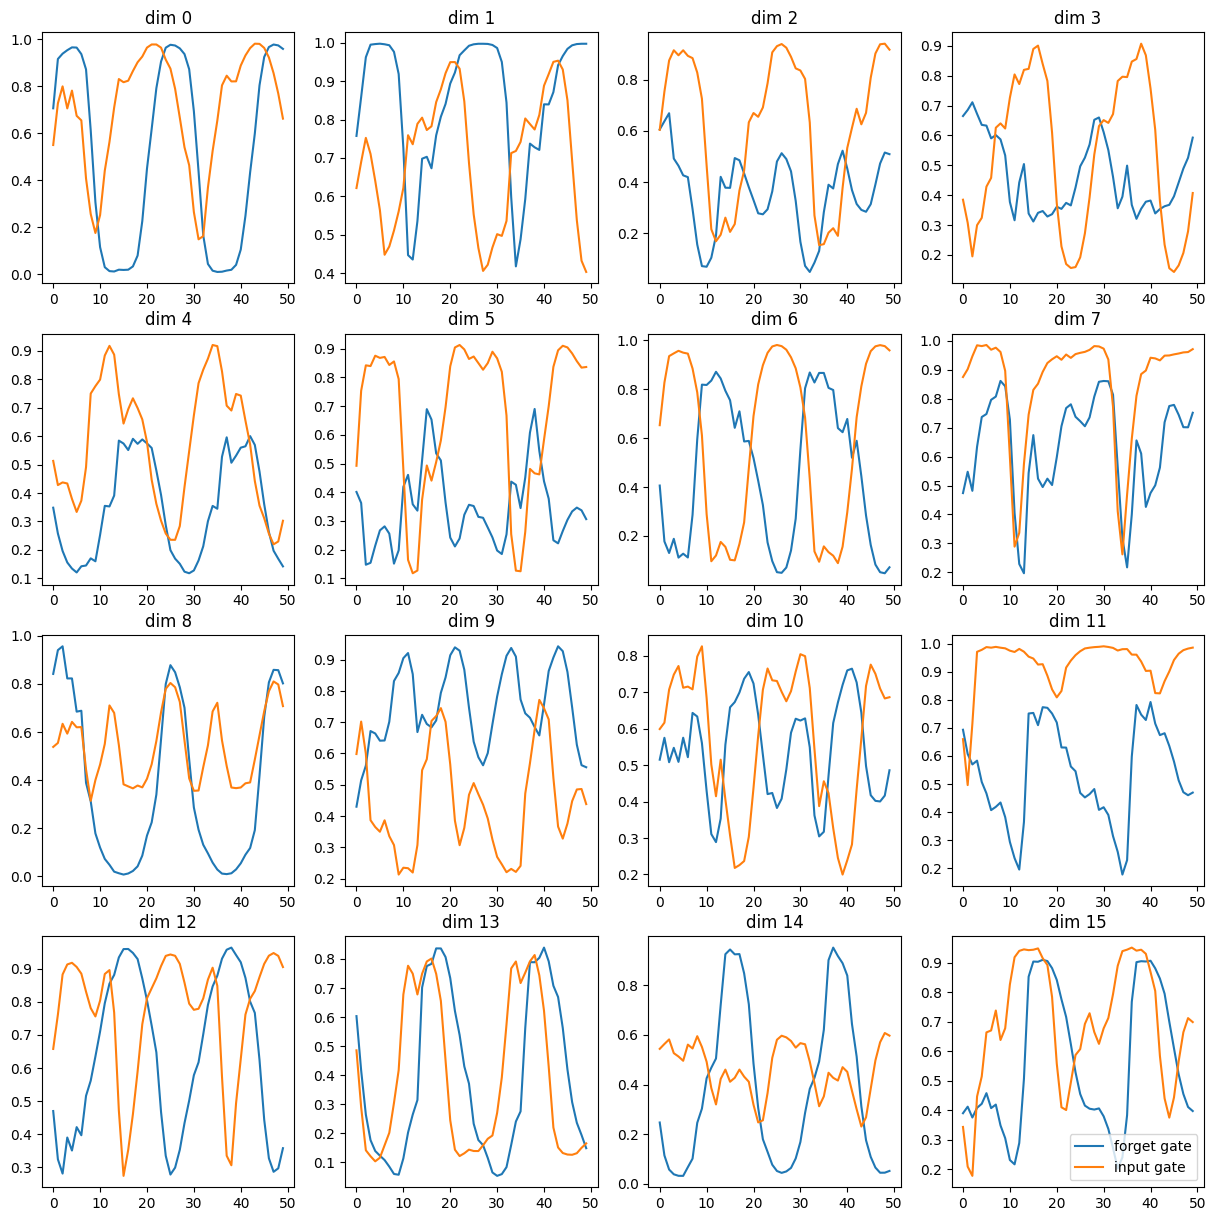

In [14]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate = [[t[rand_sample, d].item() for t in history_lstm["forget"]] for d in range(16)]
input_gate = [[t[rand_sample, d].item() for t in history_lstm["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

## DDPM Training

In [14]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [15]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
ddpm_model = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)

--- Training DDPM on cpu ---


Epoch 1/5: 100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


Epoch 1 | Loss 1.01695


Epoch 2/5: 100%|██████████| 1/1 [00:09<00:00,  9.66s/it]


Epoch 2 | Loss 0.99955


Epoch 3/5: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


Epoch 3 | Loss 0.99746


Epoch 4/5: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]


Epoch 4 | Loss 0.98841


Epoch 5/5: 100%|██████████| 1/1 [00:09<00:00,  9.84s/it]


Epoch 5 | Loss 0.99059


Text(0.5, 0, 'epoch')

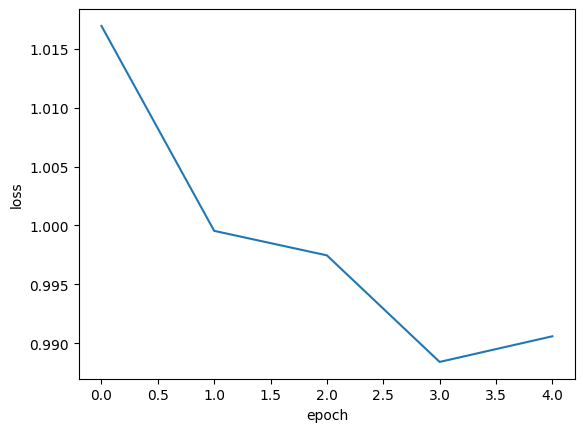

In [ ]:
losses = train_ddpm(checkpoint_path="checkpoints/ddpm_checkpoint", model=ddpm_model, data=train_dataset, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")

Starting inference on cpu with 1000 steps...


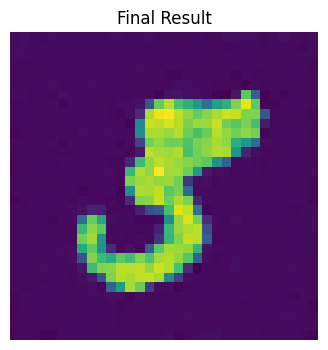

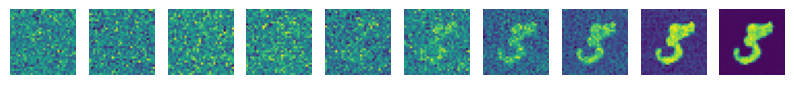

In [50]:
history_ddpm = inference(ddpm_model=ddpm_model, num_time_steps=n_T)

Starting inference on cpu with 1000 steps...


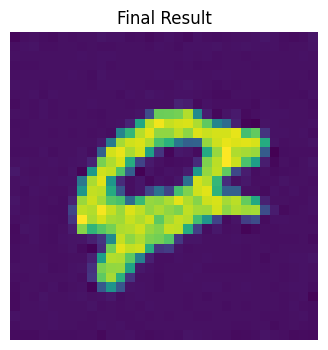

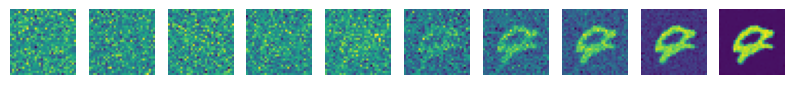

In [16]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)

In [20]:
history_ddpm["drift"][0].shape

(1, 1, 32, 32)

## Comparison

In [17]:
def run_rd_exp(history):
    print("=== RD Analysis ===")
    
    diff_forces, react_forces = [], []
    dx = history["dx"]
    F = history["F"]
    k = history["k"]
    D_u = history["D_u"]
    D_v = history["D_v"]

    for t in range(len(history["V"])):
        U_t = history["U"][t]
        V_t = history["V"][t]

        lap_V = torch.tensor(laplacian(V_t, dx))
        f_diff = torch.mean(torch.linalg.norm(D_v * lap_V)).item()

        uv2 = U_t * V_t**2
        reaction_V = torch.tensor(uv2 - (F + k) * V_t)
        f_react = torch.mean(torch.linalg.norm(reaction_V)).item()

        diff_forces.append(f_diff)
        react_forces.append(f_react)

    # Metrics: Mean magnitude per cell
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"RD Diffusion Force: {m_diff}")
    print(f"RD Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces


def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
        C_prev = history["cell"][t-1] if t > 0 else torch.zeros_like(C_t)
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.linalg.norm(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.linalg.norm((1 - f_t) * C_prev)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff}")
    print(f"LSTM Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history_ddpm["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.linalg.norm(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.linalg.norm(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff}")
    print(f"DDPM Drift Force (React): {m_react}")
    
    return m_diff, m_react, noise_forces, drift_forces


In [29]:
rd_diff_mean_list, rd_react_mean_list, rd_diff_history_list, rd_react_history_list = [], [], [], []
lstm_diff_mean_list, lstm_react_mean_list, lstm_diff_history_list, lstm_react_history_list = [], [], [], []
ddpm_diff_mean_list, ddpm_react_mean_list, ddpm_diff_history_list, ddpm_react_history_list = [], [], [], []

n_simul = 10

In [30]:
F_list = np.linspace(0.029, 0.0545, n_simul) # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 15000
for f in F_list:
    gs = GrayScott(F=f, k=k,D_u=D_u, D_v=D_v, N=256)
    U, V, V_history, stability_time, diff_history_rd, history_rd = gs.forward(0,T_max, frame=True, data=False)
    rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(history_rd)
    rd_diff_mean_list.append(rd_diff)
    rd_react_mean_list.append(rd_react)
    rd_diff_history_list.append(rd_diff_list)
    rd_react_history_list.append(rd_react_list)

F=0.029, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:18<00:00, 652.00it/s]


=== RD Analysis ===
RD Diffusion Force: 0.820723685195331
RD Reaction Force:  0.8254040885184547


F=0.032, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:18<00:00, 653.11it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8914831710659177
RD Reaction Force:  0.8983608030480272


F=0.035, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:21<00:00, 565.11it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8781697770519791
RD Reaction Force:  0.8858556924138876


F=0.037, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:25<00:00, 491.04it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8574540815839606
RD Reaction Force:  0.86502761411802


F=0.040, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:22<00:00, 555.37it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8274577922986593
RD Reaction Force:  0.835218871655766


F=0.043, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:23<00:00, 524.17it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8476364809513605
RD Reaction Force:  0.8543774265073781


F=0.046, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:17<00:00, 685.57it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8642380840393146
RD Reaction Force:  0.8714289798571265


F=0.049, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:21<00:00, 571.76it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8710179968888933
RD Reaction Force:  0.8791604069960665


F=0.052, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:22<00:00, 550.40it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8896492700028782
RD Reaction Force:  0.8971205295900038


F=0.054, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:20<00:00, 602.55it/s]


=== RD Analysis ===
RD Diffusion Force: 0.9091175137204179
RD Reaction Force:  0.9164204150165047


In [31]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated, history_lstm_gen = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff, lstm_react, lstm_diff_list, lstm_react_list = run_lstm_exp(history_lstm_gen)
    lstm_diff_mean_list.append(lstm_diff)
    lstm_react_mean_list.append(lstm_react)
    lstm_diff_history_list.append(lstm_diff_list)
    lstm_react_history_list.append(lstm_react_list)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.4037472563560562
LSTM Reaction Force:  1.4499489707176132
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4051614722820243
LSTM Reaction Force:  1.4623793772976807
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4027545482221275
LSTM Reaction Force:  1.4537378802443996
=== LSTM Analysis ===
LSTM Diffusion Force: 1.3838623756110067
LSTM Reaction Force:  1.4251143673453668
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4065877009521832
LSTM Reaction Force:  1.4461984971557
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4139745229422445
LSTM Reaction Force:  1.4516068865554501
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4083631243368593
LSTM Reaction Force:  1.463546973286253
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4061900822803228
LSTM Reaction Force:  1.4593218372325705
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4065877009521832
LSTM Reaction Force:  1.4461984971557
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4044906093616678
LSTM Rea

Starting inference on cpu with 1000 steps...


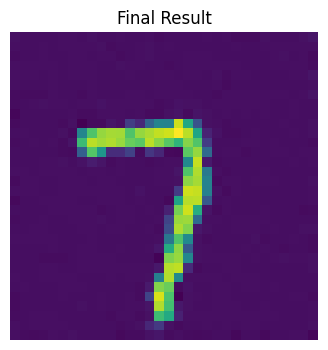

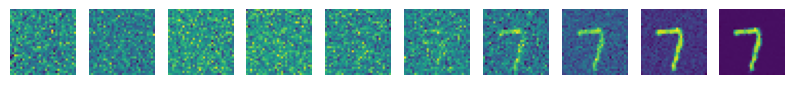

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0286259519457817
DDPM Drift Force (React): 0.2147809598594904
Starting inference on cpu with 1000 steps...


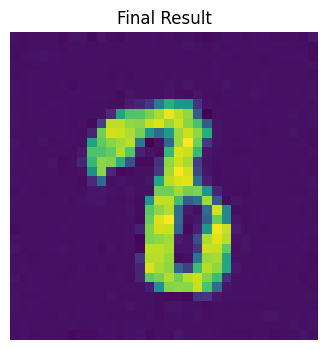

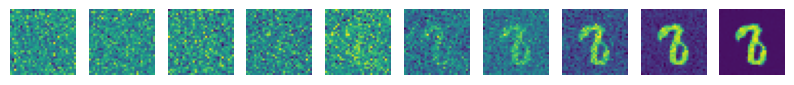

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.030922774523497
DDPM Drift Force (React): 0.2140598176419735
Starting inference on cpu with 1000 steps...


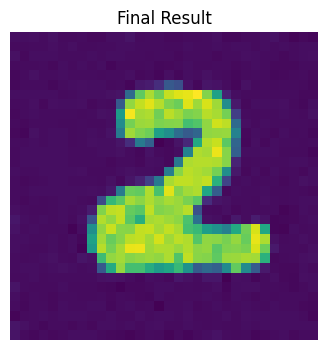

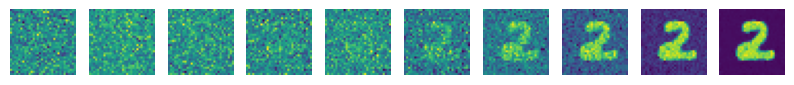

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0314850375652314
DDPM Drift Force (React): 0.21459387850761413
Starting inference on cpu with 1000 steps...


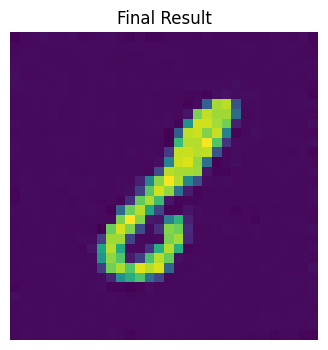

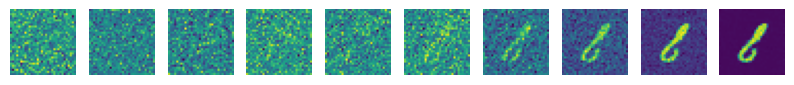

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.029723715275526
DDPM Drift Force (React): 0.21324990674853325
Starting inference on cpu with 1000 steps...


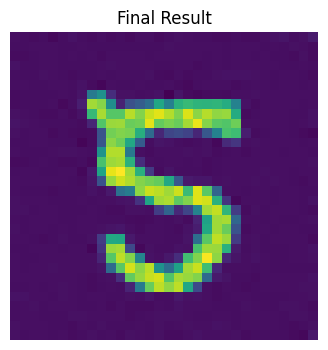

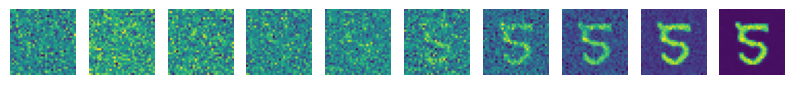

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.029710568755865
DDPM Drift Force (React): 0.2133552015721798
Starting inference on cpu with 1000 steps...


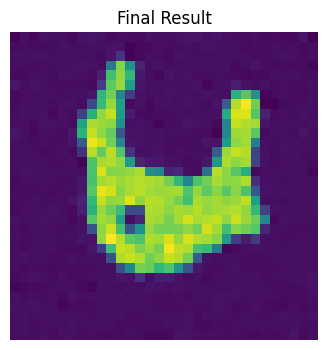

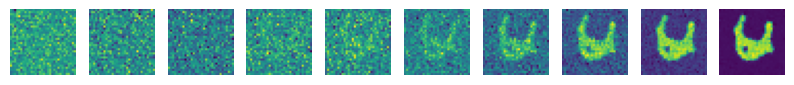

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.03159915086627
DDPM Drift Force (React): 0.21168809302151204
Starting inference on cpu with 1000 steps...


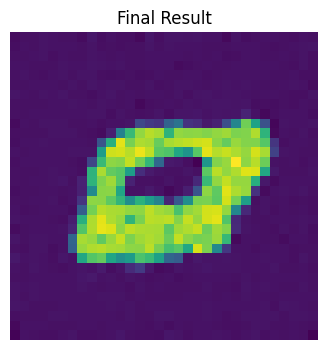

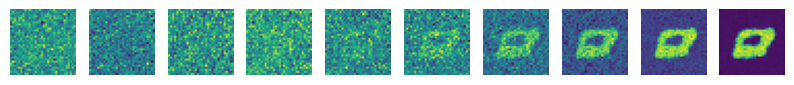

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0333101303875445
DDPM Drift Force (React): 0.2150004188865423
Starting inference on cpu with 1000 steps...


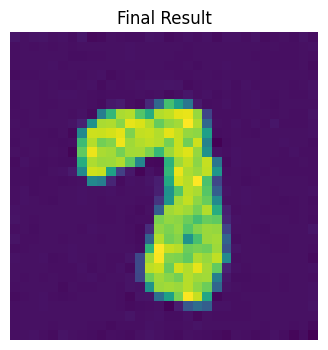

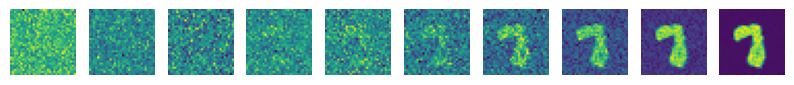

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0302929607927798
DDPM Drift Force (React): 0.21126655240356923
Starting inference on cpu with 1000 steps...


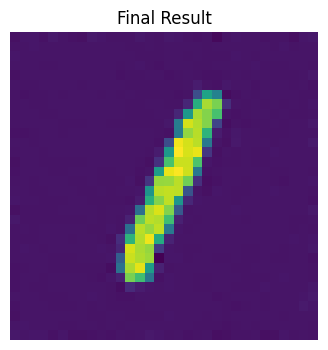

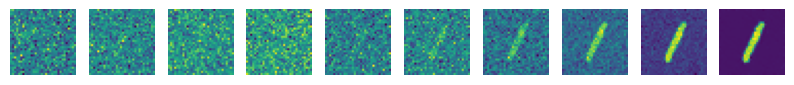

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.028415855050087
DDPM Drift Force (React): 0.21188726986944675
Starting inference on cpu with 1000 steps...


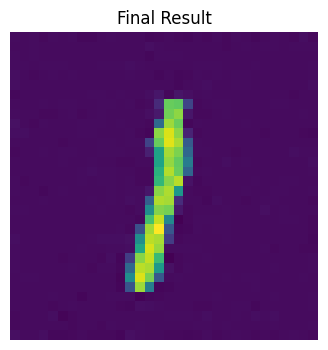

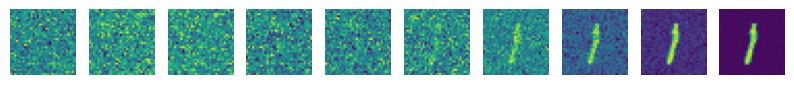

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295660200715067
DDPM Drift Force (React): 0.21783347211778165


In [32]:
for _ in range(n_simul):
    history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)
    ddpm_diff, ddpm_react, ddpm_diff_list, ddpm_react_list = run_ddpm_exp(history_ddpm)
    ddpm_diff_mean_list.append(ddpm_diff)
    ddpm_react_mean_list.append(ddpm_react)
    ddpm_diff_history_list.append(ddpm_diff_list)
    ddpm_react_history_list.append(ddpm_react_list)

In [33]:
# Calculate Ratios
rd_ratio = rd_react / (rd_diff if rd_diff != 0 else rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff if lstm_diff != 0 else lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff if ddpm_diff != 0 else ddpm_diff + 1e-10)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (react/diff)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.8f} | {rd_react:<18.8f} | {rd_ratio:<15.8f}")
print(f"{'LSTM':<20} | {lstm_diff:<18.8f} | {lstm_react:<18.8f} | {lstm_ratio:<15.8f}")
print(f"{'DDPM':<20} | {ddpm_diff:<18.8f} | {ddpm_react:<18.8f} | {ddpm_ratio:<15.8f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (react/diff)
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 0.90911751         | 0.91642042         | 1.00803296     
LSTM                 | 1.40449061         | 1.46041336         | 1.03981710     
DDPM                 | 3.02956602         | 0.21783347         | 0.07190253     


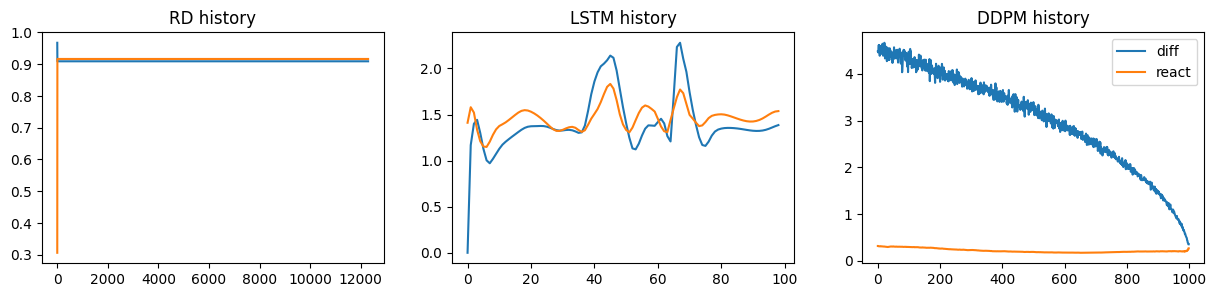

In [34]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

rand_index = random.randint(0,200)
ax[0].plot(rd_diff_list, label="diff")
ax[0].plot(rd_react_list, label="react")
ax[0].set_title("RD history")

ax[1].plot(lstm_diff_list, label="diff")
ax[1].plot(lstm_react_list, label="react")
ax[1].set_title("LSTM history")

ax[2].plot(ddpm_diff_list, label="diff")
ax[2].plot(ddpm_react_list, label="react")
ax[2].set_title("DDPM history")

plt.legend()
plt.show()

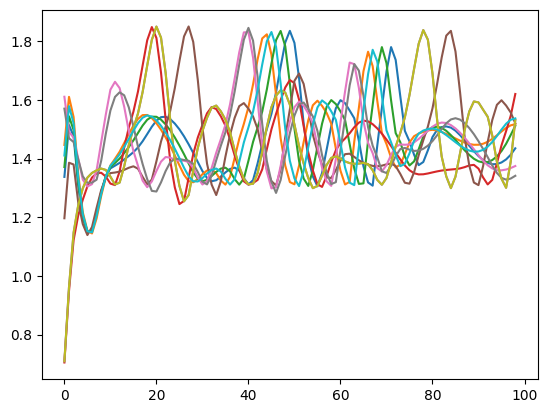

In [49]:
for i in range(n_simul):
    plt.plot(lstm_react_history_list[i])

In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs_final = gs.V[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].to("cpy").detach().numpy()
lstm_history = lstm_output[0, :, :].to("cpu").detach().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
ddpm_final_img, ddpm_history_list = ddpm_model.sample(1,)
ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062:   5%|██                                       | 400/8192 [00:01<00:19, 390.57it/s]


KeyboardInterrupt: 